In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchsummary import summary
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import numpy as np

# -----------------------------
# 1. Data Preprocessing
# -----------------------------
data_dir = "/kaggle/input/ju-cricket/Cricket_Dataset_final/Task_A"

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], 
                         [0.229, 0.224, 0.225])
])

train_ds = datasets.ImageFolder(f"{data_dir}/train", transform=transform)
val_ds   = datasets.ImageFolder(f"{data_dir}/val", transform=transform)
test_ds  = datasets.ImageFolder(f"{data_dir}/test", transform=transform)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=32, shuffle=False)

classes = train_ds.classes
print("Classes:", classes)

Classes: ['Batting', 'Bowling', 'Fielding', 'Umpire']


In [2]:
print("Total training images:", len(train_ds))
print("Total validation images:", len(val_ds))
print("Total test images:", len(test_ds))

total_images = len(train_ds) + len(val_ds) + len(test_ds)
print("Total images in dataset:", total_images)

Total training images: 11169
Total validation images: 2898
Total test images: 3627
Total images in dataset: 17694


In [3]:
ignore_folder = "random_occlusion"

def count_images_ignore_folder(dataset, ignore_folder):
    count = 0
    for img_path, label in dataset.samples:
        # Skip if the image path contains the ignore_folder
        if ignore_folder not in img_path.split("/"):
            count += 1
    return count

train_count = count_images_ignore_folder(train_ds, ignore_folder)
val_count   = count_images_ignore_folder(val_ds, ignore_folder)
test_count  = count_images_ignore_folder(test_ds, ignore_folder)

total_count = train_count + val_count + test_count

print("Training images (excluding '{}'): {}".format(ignore_folder, train_count))
print("Validation images (excluding '{}'): {}".format(ignore_folder, val_count))
print("Test images (excluding '{}'): {}".format(ignore_folder, test_count))
print("Total images (excluding '{}'): {}".format(ignore_folder, total_count))

Training images (excluding 'random_occlusion'): 9928
Validation images (excluding 'random_occlusion'): 2576
Test images (excluding 'random_occlusion'): 3224
Total images (excluding 'random_occlusion'): 15728


In [4]:
ignore_folder = "random_occlusionw"

def get_included_folders(dataset, ignore_folder):
    included = set()
    for img_path, label in dataset.samples:
        # Split the path into parts and ignore if ignore_folder is in the path
        if ignore_folder not in img_path.split("/"):
            # The folder name just above the image (or the class folder)
            folder_name = img_path.split("/")[-2]
            included.add(folder_name)
    return included

train_folders = get_included_folders(train_ds, ignore_folder)
val_folders   = get_included_folders(val_ds, ignore_folder)
test_folders  = get_included_folders(test_ds, ignore_folder)

print("Training folders considered:", train_folders)
print("Validation folders considered:", val_folders)
print("Test folders considered:", test_folders)

Training folders considered: {'gaussian_noise', 'dirty_lens', 'low_resolution', 'motion_blur', 'original', 'blur', 'lens_flare', 'random_occlusion', 'chromatic_aberration'}
Validation folders considered: {'gaussian_noise', 'dirty_lens', 'low_resolution', 'motion_blur', 'original', 'blur', 'lens_flare', 'random_occlusion', 'chromatic_aberration'}
Test folders considered: {'gaussian_noise', 'dirty_lens', 'low_resolution', 'motion_blur', 'original', 'blur', 'lens_flare', 'random_occlusion', 'chromatic_aberration'}


In [5]:
ignore_folder = "random_occlusion"

def filter_samples(dataset, ignore_folder):
    # Keep only samples where ignore_folder is NOT in the path
    filtered_samples = [s for s in dataset.samples if ignore_folder not in s[0].split("/")]
    dataset.samples = filtered_samples
    dataset.targets = [s[1] for s in filtered_samples]  # Update targets accordingly
    return dataset

# Create original datasets
train_ds = datasets.ImageFolder(f"{data_dir}/train", transform=transform)
val_ds   = datasets.ImageFolder(f"{data_dir}/val", transform=transform)
test_ds  = datasets.ImageFolder(f"{data_dir}/test", transform=transform)

# Filter out 'random_occlusion' folder
train_ds = filter_samples(train_ds, ignore_folder)
val_ds   = filter_samples(val_ds, ignore_folder)
test_ds  = filter_samples(test_ds, ignore_folder)

# DataLoaders
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=32, shuffle=False)

# Classes (will remain the same)
classes = train_ds.classes
print("Classes:", classes)

# Show counts
print("Final Training images:", len(train_ds))
print("Final Validation images:", len(val_ds))
print("Final Test images:", len(test_ds))
print("Total images after filtering:", len(train_ds) + len(val_ds) + len(test_ds))

Classes: ['Batting', 'Bowling', 'Fielding', 'Umpire']
Final Training images: 9928
Final Validation images: 2576
Final Test images: 3224
Total images after filtering: 15728


In [6]:
ignore_folder = "random_occlusion"

def get_included_folders(dataset, ignore_folder):
    included = set()
    for img_path, label in dataset.samples:
        # Split the path into parts and ignore if ignore_folder is in the path
        if ignore_folder not in img_path.split("/"):
            # The folder name just above the image (or the class folder)
            folder_name = img_path.split("/")[-2]
            included.add(folder_name)
    return included

train_folders = get_included_folders(train_ds, ignore_folder)
val_folders   = get_included_folders(val_ds, ignore_folder)
test_folders  = get_included_folders(test_ds, ignore_folder)

print("Training folders considered:", train_folders)
print("Validation folders considered:", val_folders)
print("Test folders considered:", test_folders)

Training folders considered: {'gaussian_noise', 'dirty_lens', 'low_resolution', 'motion_blur', 'original', 'blur', 'lens_flare', 'chromatic_aberration'}
Validation folders considered: {'gaussian_noise', 'dirty_lens', 'low_resolution', 'motion_blur', 'original', 'blur', 'lens_flare', 'chromatic_aberration'}
Test folders considered: {'gaussian_noise', 'dirty_lens', 'low_resolution', 'motion_blur', 'original', 'blur', 'lens_flare', 'chromatic_aberration'}


In [7]:
import seaborn as sns
import numpy as np
import time
from tqdm import tqdm

In [8]:
# -----------------------------
# 2. Define ResNet50 Model from Scratch
# -----------------------------
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torchsummary import summary
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pandas as pd
from tqdm import tqdm
import time

class Bottleneck(nn.Module):
    """Bottleneck block for ResNet50"""
    expansion = 4
    
    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super().__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * self.expansion, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride
    
    def forward(self, x):
        identity = x
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        
        out = self.conv3(out)
        out = self.bn3(out)
        
        if self.downsample is not None:
            identity = self.downsample(x)
        
        out += identity
        out = self.relu(out)
        
        return out

class MyResNet50(nn.Module):
    """ResNet50 Implementation from Scratch"""
    def __init__(self, num_classes=4, zero_init_residual=False):
        super().__init__()
        self.inplanes = 64
        
        # Initial convolution and pooling layers
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        # Residual layers
        self.layer1 = self._make_layer(64, 3)
        self.layer2 = self._make_layer(128, 4, stride=2)
        self.layer3 = self._make_layer(256, 6, stride=2)
        self.layer4 = self._make_layer(512, 3, stride=2)
        
        # Final layers
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * Bottleneck.expansion, num_classes)
        
        # Initialize weights
        self._initialize_weights(zero_init_residual)
    
    def _make_layer(self, planes, blocks, stride=1):
        """Create a residual layer with specified number of blocks"""
        downsample = None
        if stride != 1 or self.inplanes != planes * Bottleneck.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * Bottleneck.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * Bottleneck.expansion),
            )
        
        layers = []
        layers.append(Bottleneck(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * Bottleneck.expansion
        for _ in range(1, blocks):
            layers.append(Bottleneck(self.inplanes, planes))
        
        return nn.Sequential(*layers)
    
    def _initialize_weights(self, zero_init_residual):
        """Initialize weights using He initialization"""
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)
        
        # Zero-initialize the last BN in each residual branch for better training
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        
        return x

In [9]:
# -----------------------------
# 3. Training Setup
# -----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MyResNet50(num_classes=len(classes), zero_init_residual=True).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-4)

print("ResNet50 Model Summary:")
try:
    summary(model, (3, 224, 224))
except:
    print("Model summary generation failed - this is normal for complex architectures")
    print(f"Model created successfully with {sum(p.numel() for p in model.parameters()):,} parameters")

ResNet50 Model Summary:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm


🚀 Starting ResNet50 Training for 50 epochs...

📈 Epoch 1/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 311/311 [03:42<00:00,  1.40it/s, Loss=1.5725, Acc=0.5026, GPU=0.3GB]


✅ Training completed in 222.87s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 81/81 [00:40<00:00,  1.99it/s, Loss=1.1313, Acc=0.5256]


✅ Validation completed in 40.62s
🌟 New best ResNet50 model found! Validation Accuracy: 0.5256

📊 Epoch 1 Summary:
│ Train Loss: 1.5725 | Train Acc: 0.5026
│ Val Loss:   1.1313 | Val Acc:   0.5256
│ Train Time: 222.87s | Val Time: 40.62s
│ Total Epoch Time: 263.50s
│ Best Val Acc: 0.5256 (Epoch 1)
│ GPU Memory: 0.3GB / 3.2GB

📈 Epoch 2/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 311/311 [02:39<00:00,  1.95it/s, Loss=1.0530, Acc=0.5535, GPU=0.3GB]


✅ Training completed in 159.82s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 81/81 [00:24<00:00,  3.36it/s, Loss=1.1055, Acc=0.5450]


✅ Validation completed in 24.13s
🌟 New best ResNet50 model found! Validation Accuracy: 0.5450

📊 Epoch 2 Summary:
│ Train Loss: 1.0530 | Train Acc: 0.5535
│ Val Loss:   1.1055 | Val Acc:   0.5450
│ Train Time: 159.82s | Val Time: 24.13s
│ Total Epoch Time: 183.96s
│ Best Val Acc: 0.5450 (Epoch 2)
│ GPU Memory: 0.3GB / 3.2GB

📈 Epoch 3/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 311/311 [02:40<00:00,  1.94it/s, Loss=0.9260, Acc=0.6203, GPU=0.3GB]


✅ Training completed in 160.04s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 81/81 [00:24<00:00,  3.31it/s, Loss=1.3595, Acc=0.5512]


✅ Validation completed in 24.49s
🌟 New best ResNet50 model found! Validation Accuracy: 0.5512

📊 Epoch 3 Summary:
│ Train Loss: 0.9260 | Train Acc: 0.6203
│ Val Loss:   1.3595 | Val Acc:   0.5512
│ Train Time: 160.04s | Val Time: 24.49s
│ Total Epoch Time: 184.54s
│ Best Val Acc: 0.5512 (Epoch 3)
│ GPU Memory: 0.3GB / 3.2GB

📈 Epoch 4/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 311/311 [02:40<00:00,  1.94it/s, Loss=0.7393, Acc=0.7047, GPU=0.3GB]


✅ Training completed in 160.05s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 81/81 [00:24<00:00,  3.29it/s, Loss=1.1339, Acc=0.6250]


✅ Validation completed in 24.62s
🌟 New best ResNet50 model found! Validation Accuracy: 0.6250

📊 Epoch 4 Summary:
│ Train Loss: 0.7393 | Train Acc: 0.7047
│ Val Loss:   1.1339 | Val Acc:   0.6250
│ Train Time: 160.05s | Val Time: 24.62s
│ Total Epoch Time: 184.68s
│ Best Val Acc: 0.6250 (Epoch 4)
│ GPU Memory: 0.3GB / 3.2GB

📈 Epoch 5/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 311/311 [02:40<00:00,  1.94it/s, Loss=0.5109, Acc=0.8067, GPU=0.3GB]


✅ Training completed in 160.08s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 81/81 [00:24<00:00,  3.34it/s, Loss=1.4615, Acc=0.6308]


✅ Validation completed in 24.28s
🌟 New best ResNet50 model found! Validation Accuracy: 0.6308

📊 Epoch 5 Summary:
│ Train Loss: 0.5109 | Train Acc: 0.8067
│ Val Loss:   1.4615 | Val Acc:   0.6308
│ Train Time: 160.08s | Val Time: 24.28s
│ Total Epoch Time: 184.36s
│ Best Val Acc: 0.6308 (Epoch 5)
│ GPU Memory: 0.3GB / 3.2GB

📈 Epoch 6/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 311/311 [02:40<00:00,  1.94it/s, Loss=0.3228, Acc=0.8816, GPU=0.3GB]


✅ Training completed in 160.71s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 81/81 [00:24<00:00,  3.32it/s, Loss=1.8200, Acc=0.5819]


✅ Validation completed in 24.38s

📊 Epoch 6 Summary:
│ Train Loss: 0.3228 | Train Acc: 0.8816
│ Val Loss:   1.8200 | Val Acc:   0.5819
│ Train Time: 160.71s | Val Time: 24.38s
│ Total Epoch Time: 185.09s
│ Best Val Acc: 0.6308 (Epoch 5)
│ GPU Memory: 0.3GB / 3.2GB

📈 Epoch 7/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 311/311 [02:42<00:00,  1.92it/s, Loss=0.1943, Acc=0.9312, GPU=0.3GB]


✅ Training completed in 162.33s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 81/81 [00:25<00:00,  3.23it/s, Loss=1.6431, Acc=0.6366]


✅ Validation completed in 25.06s
🌟 New best ResNet50 model found! Validation Accuracy: 0.6366

📊 Epoch 7 Summary:
│ Train Loss: 0.1943 | Train Acc: 0.9312
│ Val Loss:   1.6431 | Val Acc:   0.6366
│ Train Time: 162.33s | Val Time: 25.06s
│ Total Epoch Time: 187.39s
│ Best Val Acc: 0.6366 (Epoch 7)
│ GPU Memory: 0.3GB / 3.2GB

📈 Epoch 8/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 311/311 [02:40<00:00,  1.94it/s, Loss=0.1189, Acc=0.9612, GPU=0.3GB]


✅ Training completed in 160.24s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 81/81 [00:24<00:00,  3.28it/s, Loss=2.2462, Acc=0.5769]


✅ Validation completed in 24.72s

📊 Epoch 8 Summary:
│ Train Loss: 0.1189 | Train Acc: 0.9612
│ Val Loss:   2.2462 | Val Acc:   0.5769
│ Train Time: 160.24s | Val Time: 24.72s
│ Total Epoch Time: 184.97s
│ Best Val Acc: 0.6366 (Epoch 7)
│ GPU Memory: 0.3GB / 3.2GB

📈 Epoch 9/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 311/311 [02:40<00:00,  1.94it/s, Loss=0.1160, Acc=0.9605, GPU=0.3GB]


✅ Training completed in 160.51s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 81/81 [00:25<00:00,  3.21it/s, Loss=1.8723, Acc=0.6378]


✅ Validation completed in 25.27s
🌟 New best ResNet50 model found! Validation Accuracy: 0.6378

📊 Epoch 9 Summary:
│ Train Loss: 0.1160 | Train Acc: 0.9605
│ Val Loss:   1.8723 | Val Acc:   0.6378
│ Train Time: 160.51s | Val Time: 25.27s
│ Total Epoch Time: 185.79s
│ Best Val Acc: 0.6378 (Epoch 9)
│ GPU Memory: 0.3GB / 3.2GB

📈 Epoch 10/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 311/311 [02:42<00:00,  1.91it/s, Loss=0.0563, Acc=0.9810, GPU=0.3GB]


✅ Training completed in 162.68s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 81/81 [00:24<00:00,  3.31it/s, Loss=1.7504, Acc=0.6487]


✅ Validation completed in 24.50s
🌟 New best ResNet50 model found! Validation Accuracy: 0.6487

📊 Epoch 10 Summary:
│ Train Loss: 0.0563 | Train Acc: 0.9810
│ Val Loss:   1.7504 | Val Acc:   0.6487
│ Train Time: 162.68s | Val Time: 24.50s
│ Total Epoch Time: 187.19s
│ Best Val Acc: 0.6487 (Epoch 10)
│ GPU Memory: 0.3GB / 3.2GB

📈 Epoch 11/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 311/311 [02:43<00:00,  1.91it/s, Loss=0.0528, Acc=0.9806, GPU=0.3GB]


✅ Training completed in 163.05s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 81/81 [00:24<00:00,  3.25it/s, Loss=2.0684, Acc=0.6281]


✅ Validation completed in 24.90s

📊 Epoch 11 Summary:
│ Train Loss: 0.0528 | Train Acc: 0.9806
│ Val Loss:   2.0684 | Val Acc:   0.6281
│ Train Time: 163.05s | Val Time: 24.90s
│ Total Epoch Time: 187.95s
│ Best Val Acc: 0.6487 (Epoch 10)
│ GPU Memory: 0.3GB / 3.2GB

📈 Epoch 12/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 311/311 [02:42<00:00,  1.92it/s, Loss=0.0522, Acc=0.9846, GPU=0.3GB]


✅ Training completed in 162.34s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 81/81 [00:24<00:00,  3.28it/s, Loss=1.9195, Acc=0.6700]


✅ Validation completed in 24.68s
🌟 New best ResNet50 model found! Validation Accuracy: 0.6700

📊 Epoch 12 Summary:
│ Train Loss: 0.0522 | Train Acc: 0.9846
│ Val Loss:   1.9195 | Val Acc:   0.6700
│ Train Time: 162.34s | Val Time: 24.68s
│ Total Epoch Time: 187.02s
│ Best Val Acc: 0.6700 (Epoch 12)
│ GPU Memory: 0.3GB / 3.2GB

📈 Epoch 13/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 311/311 [02:41<00:00,  1.93it/s, Loss=0.0249, Acc=0.9933, GPU=0.3GB]


✅ Training completed in 161.56s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 81/81 [00:24<00:00,  3.29it/s, Loss=2.1102, Acc=0.6495]


✅ Validation completed in 24.64s

📊 Epoch 13 Summary:
│ Train Loss: 0.0249 | Train Acc: 0.9933
│ Val Loss:   2.1102 | Val Acc:   0.6495
│ Train Time: 161.56s | Val Time: 24.64s
│ Total Epoch Time: 186.19s
│ Best Val Acc: 0.6700 (Epoch 12)
│ GPU Memory: 0.3GB / 3.2GB

📈 Epoch 14/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 311/311 [02:41<00:00,  1.92it/s, Loss=0.0499, Acc=0.9823, GPU=0.3GB]


✅ Training completed in 161.92s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 81/81 [00:25<00:00,  3.22it/s, Loss=2.2071, Acc=0.6432]


✅ Validation completed in 25.15s

📊 Epoch 14 Summary:
│ Train Loss: 0.0499 | Train Acc: 0.9823
│ Val Loss:   2.2071 | Val Acc:   0.6432
│ Train Time: 161.92s | Val Time: 25.15s
│ Total Epoch Time: 187.07s
│ Best Val Acc: 0.6700 (Epoch 12)
│ GPU Memory: 0.3GB / 3.2GB

📈 Epoch 15/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 311/311 [02:42<00:00,  1.92it/s, Loss=0.0380, Acc=0.9879, GPU=0.3GB]


✅ Training completed in 162.19s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 81/81 [00:24<00:00,  3.32it/s, Loss=1.8738, Acc=0.6689]


✅ Validation completed in 24.41s

📊 Epoch 15 Summary:
│ Train Loss: 0.0380 | Train Acc: 0.9879
│ Val Loss:   1.8738 | Val Acc:   0.6689
│ Train Time: 162.19s | Val Time: 24.41s
│ Total Epoch Time: 186.60s
│ Best Val Acc: 0.6700 (Epoch 12)
│ GPU Memory: 0.3GB / 3.2GB

📈 Epoch 16/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 311/311 [02:41<00:00,  1.92it/s, Loss=0.0286, Acc=0.9908, GPU=0.3GB]


✅ Training completed in 161.99s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 81/81 [00:24<00:00,  3.28it/s, Loss=2.1119, Acc=0.6153]


✅ Validation completed in 24.69s

📊 Epoch 16 Summary:
│ Train Loss: 0.0286 | Train Acc: 0.9908
│ Val Loss:   2.1119 | Val Acc:   0.6153
│ Train Time: 161.99s | Val Time: 24.69s
│ Total Epoch Time: 186.68s
│ Best Val Acc: 0.6700 (Epoch 12)
│ GPU Memory: 0.3GB / 3.2GB

📈 Epoch 17/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 311/311 [02:41<00:00,  1.93it/s, Loss=0.0524, Acc=0.9828, GPU=0.3GB]


✅ Training completed in 161.32s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 81/81 [00:24<00:00,  3.33it/s, Loss=1.6808, Acc=0.6999]


✅ Validation completed in 24.36s
🌟 New best ResNet50 model found! Validation Accuracy: 0.6999

📊 Epoch 17 Summary:
│ Train Loss: 0.0524 | Train Acc: 0.9828
│ Val Loss:   1.6808 | Val Acc:   0.6999
│ Train Time: 161.32s | Val Time: 24.36s
│ Total Epoch Time: 185.68s
│ Best Val Acc: 0.6999 (Epoch 17)
│ GPU Memory: 0.3GB / 3.2GB

📈 Epoch 18/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 311/311 [02:41<00:00,  1.93it/s, Loss=0.0117, Acc=0.9970, GPU=0.3GB]


✅ Training completed in 161.22s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 81/81 [00:24<00:00,  3.33it/s, Loss=1.8508, Acc=0.6813]


✅ Validation completed in 24.29s

📊 Epoch 18 Summary:
│ Train Loss: 0.0117 | Train Acc: 0.9970
│ Val Loss:   1.8508 | Val Acc:   0.6813
│ Train Time: 161.22s | Val Time: 24.29s
│ Total Epoch Time: 185.52s
│ Best Val Acc: 0.6999 (Epoch 17)
│ GPU Memory: 0.3GB / 3.2GB

📈 Epoch 19/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 311/311 [02:41<00:00,  1.92it/s, Loss=0.0366, Acc=0.9886, GPU=0.3GB]


✅ Training completed in 161.70s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 81/81 [00:24<00:00,  3.30it/s, Loss=1.8935, Acc=0.6840]


✅ Validation completed in 24.57s

📊 Epoch 19 Summary:
│ Train Loss: 0.0366 | Train Acc: 0.9886
│ Val Loss:   1.8935 | Val Acc:   0.6840
│ Train Time: 161.70s | Val Time: 24.57s
│ Total Epoch Time: 186.27s
│ Best Val Acc: 0.6999 (Epoch 17)
│ GPU Memory: 0.3GB / 3.2GB

📈 Epoch 20/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 311/311 [02:40<00:00,  1.94it/s, Loss=0.0080, Acc=0.9983, GPU=0.3GB]


✅ Training completed in 160.39s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 81/81 [00:24<00:00,  3.36it/s, Loss=1.9238, Acc=0.6561]


✅ Validation completed in 24.08s

📊 Epoch 20 Summary:
│ Train Loss: 0.0080 | Train Acc: 0.9983
│ Val Loss:   1.9238 | Val Acc:   0.6561
│ Train Time: 160.39s | Val Time: 24.08s
│ Total Epoch Time: 184.47s
│ Best Val Acc: 0.6999 (Epoch 17)
│ GPU Memory: 0.3GB / 3.2GB

📈 Epoch 21/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 311/311 [02:39<00:00,  1.95it/s, Loss=0.0048, Acc=0.9989, GPU=0.3GB]


✅ Training completed in 159.65s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 81/81 [00:24<00:00,  3.35it/s, Loss=1.7788, Acc=0.6906]


✅ Validation completed in 24.18s

📊 Epoch 21 Summary:
│ Train Loss: 0.0048 | Train Acc: 0.9989
│ Val Loss:   1.7788 | Val Acc:   0.6906
│ Train Time: 159.65s | Val Time: 24.18s
│ Total Epoch Time: 183.83s
│ Best Val Acc: 0.6999 (Epoch 17)
│ GPU Memory: 0.3GB / 3.2GB

📈 Epoch 22/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 311/311 [02:41<00:00,  1.92it/s, Loss=0.0227, Acc=0.9920, GPU=0.3GB]


✅ Training completed in 161.75s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 81/81 [00:24<00:00,  3.25it/s, Loss=1.7654, Acc=0.6677]


✅ Validation completed in 24.95s

📊 Epoch 22 Summary:
│ Train Loss: 0.0227 | Train Acc: 0.9920
│ Val Loss:   1.7654 | Val Acc:   0.6677
│ Train Time: 161.75s | Val Time: 24.95s
│ Total Epoch Time: 186.70s
│ Best Val Acc: 0.6999 (Epoch 17)
│ GPU Memory: 0.3GB / 3.2GB

📈 Epoch 23/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 311/311 [02:44<00:00,  1.89it/s, Loss=0.0550, Acc=0.9823, GPU=0.3GB]


✅ Training completed in 164.85s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 81/81 [00:24<00:00,  3.25it/s, Loss=1.6885, Acc=0.6863]


✅ Validation completed in 24.89s

📊 Epoch 23 Summary:
│ Train Loss: 0.0550 | Train Acc: 0.9823
│ Val Loss:   1.6885 | Val Acc:   0.6863
│ Train Time: 164.85s | Val Time: 24.89s
│ Total Epoch Time: 189.75s
│ Best Val Acc: 0.6999 (Epoch 17)
│ GPU Memory: 0.3GB / 3.2GB

📈 Epoch 24/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 311/311 [02:42<00:00,  1.91it/s, Loss=0.0173, Acc=0.9950, GPU=0.3GB]


✅ Training completed in 162.90s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 81/81 [00:24<00:00,  3.26it/s, Loss=1.9384, Acc=0.6755]


✅ Validation completed in 24.88s

📊 Epoch 24 Summary:
│ Train Loss: 0.0173 | Train Acc: 0.9950
│ Val Loss:   1.9384 | Val Acc:   0.6755
│ Train Time: 162.90s | Val Time: 24.88s
│ Total Epoch Time: 187.78s
│ Best Val Acc: 0.6999 (Epoch 17)
│ GPU Memory: 0.3GB / 3.2GB

📈 Epoch 25/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 311/311 [02:41<00:00,  1.92it/s, Loss=0.0200, Acc=0.9933, GPU=0.3GB]


✅ Training completed in 161.68s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 81/81 [00:24<00:00,  3.26it/s, Loss=1.8963, Acc=0.6844]


✅ Validation completed in 24.86s

📊 Epoch 25 Summary:
│ Train Loss: 0.0200 | Train Acc: 0.9933
│ Val Loss:   1.8963 | Val Acc:   0.6844
│ Train Time: 161.68s | Val Time: 24.86s
│ Total Epoch Time: 186.54s
│ Best Val Acc: 0.6999 (Epoch 17)
│ GPU Memory: 0.3GB / 3.2GB

📈 Epoch 26/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 311/311 [02:41<00:00,  1.92it/s, Loss=0.0291, Acc=0.9897, GPU=0.3GB]


✅ Training completed in 161.97s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 81/81 [00:24<00:00,  3.32it/s, Loss=2.2169, Acc=0.6421]


✅ Validation completed in 24.40s

📊 Epoch 26 Summary:
│ Train Loss: 0.0291 | Train Acc: 0.9897
│ Val Loss:   2.2169 | Val Acc:   0.6421
│ Train Time: 161.97s | Val Time: 24.40s
│ Total Epoch Time: 186.37s
│ Best Val Acc: 0.6999 (Epoch 17)
│ GPU Memory: 0.3GB / 3.2GB

📈 Epoch 27/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 311/311 [02:42<00:00,  1.92it/s, Loss=0.0464, Acc=0.9848, GPU=0.3GB]


✅ Training completed in 162.01s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 81/81 [00:24<00:00,  3.28it/s, Loss=2.0046, Acc=0.6828]


✅ Validation completed in 24.69s

📊 Epoch 27 Summary:
│ Train Loss: 0.0464 | Train Acc: 0.9848
│ Val Loss:   2.0046 | Val Acc:   0.6828
│ Train Time: 162.01s | Val Time: 24.69s
│ Total Epoch Time: 186.71s
│ Best Val Acc: 0.6999 (Epoch 17)
│ GPU Memory: 0.3GB / 3.2GB

📈 Epoch 28/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 311/311 [02:41<00:00,  1.92it/s, Loss=0.0411, Acc=0.9860, GPU=0.3GB]


✅ Training completed in 161.88s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 81/81 [00:24<00:00,  3.33it/s, Loss=1.9737, Acc=0.6219]


✅ Validation completed in 24.32s

📊 Epoch 28 Summary:
│ Train Loss: 0.0411 | Train Acc: 0.9860
│ Val Loss:   1.9737 | Val Acc:   0.6219
│ Train Time: 161.88s | Val Time: 24.32s
│ Total Epoch Time: 186.20s
│ Best Val Acc: 0.6999 (Epoch 17)
│ GPU Memory: 0.3GB / 3.2GB

📈 Epoch 29/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 311/311 [02:42<00:00,  1.92it/s, Loss=0.0155, Acc=0.9953, GPU=0.3GB]


✅ Training completed in 162.33s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 81/81 [00:24<00:00,  3.25it/s, Loss=1.9738, Acc=0.6941]


✅ Validation completed in 24.90s

📊 Epoch 29 Summary:
│ Train Loss: 0.0155 | Train Acc: 0.9953
│ Val Loss:   1.9738 | Val Acc:   0.6941
│ Train Time: 162.33s | Val Time: 24.90s
│ Total Epoch Time: 187.24s
│ Best Val Acc: 0.6999 (Epoch 17)
│ GPU Memory: 0.3GB / 3.2GB

📈 Epoch 30/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 311/311 [02:42<00:00,  1.91it/s, Loss=0.0622, Acc=0.9790, GPU=0.3GB]


✅ Training completed in 162.55s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 81/81 [00:24<00:00,  3.26it/s, Loss=1.6370, Acc=0.6960]


✅ Validation completed in 24.84s

📊 Epoch 30 Summary:
│ Train Loss: 0.0622 | Train Acc: 0.9790
│ Val Loss:   1.6370 | Val Acc:   0.6960
│ Train Time: 162.55s | Val Time: 24.84s
│ Total Epoch Time: 187.39s
│ Best Val Acc: 0.6999 (Epoch 17)
│ GPU Memory: 0.3GB / 3.2GB

📈 Epoch 31/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 311/311 [02:41<00:00,  1.92it/s, Loss=0.0082, Acc=0.9982, GPU=0.3GB]


✅ Training completed in 161.98s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 81/81 [00:24<00:00,  3.24it/s, Loss=1.7493, Acc=0.6949]


✅ Validation completed in 25.00s

📊 Epoch 31 Summary:
│ Train Loss: 0.0082 | Train Acc: 0.9982
│ Val Loss:   1.7493 | Val Acc:   0.6949
│ Train Time: 161.98s | Val Time: 25.00s
│ Total Epoch Time: 186.99s
│ Best Val Acc: 0.6999 (Epoch 17)
│ GPU Memory: 0.3GB / 3.2GB

📈 Epoch 32/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 311/311 [02:41<00:00,  1.93it/s, Loss=0.0029, Acc=0.9994, GPU=0.3GB]


✅ Training completed in 161.11s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 81/81 [00:24<00:00,  3.36it/s, Loss=1.7572, Acc=0.6933]


✅ Validation completed in 24.08s

📊 Epoch 32 Summary:
│ Train Loss: 0.0029 | Train Acc: 0.9994
│ Val Loss:   1.7572 | Val Acc:   0.6933
│ Train Time: 161.11s | Val Time: 24.08s
│ Total Epoch Time: 185.19s
│ Best Val Acc: 0.6999 (Epoch 17)
│ GPU Memory: 0.3GB / 3.2GB

📈 Epoch 33/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 311/311 [02:39<00:00,  1.95it/s, Loss=0.0013, Acc=0.9998, GPU=0.3GB]


✅ Training completed in 159.47s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 81/81 [00:24<00:00,  3.30it/s, Loss=1.7451, Acc=0.6922]


✅ Validation completed in 24.55s

📊 Epoch 33 Summary:
│ Train Loss: 0.0013 | Train Acc: 0.9998
│ Val Loss:   1.7451 | Val Acc:   0.6922
│ Train Time: 159.47s | Val Time: 24.55s
│ Total Epoch Time: 184.02s
│ Best Val Acc: 0.6999 (Epoch 17)
│ GPU Memory: 0.3GB / 3.2GB

📈 Epoch 34/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 311/311 [02:41<00:00,  1.93it/s, Loss=0.0008, Acc=0.9999, GPU=0.3GB]


✅ Training completed in 161.26s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 81/81 [00:24<00:00,  3.31it/s, Loss=1.6862, Acc=0.6991]


✅ Validation completed in 24.45s

📊 Epoch 34 Summary:
│ Train Loss: 0.0008 | Train Acc: 0.9999
│ Val Loss:   1.6862 | Val Acc:   0.6991
│ Train Time: 161.26s | Val Time: 24.45s
│ Total Epoch Time: 185.71s
│ Best Val Acc: 0.6999 (Epoch 17)
│ GPU Memory: 0.3GB / 3.2GB

📈 Epoch 35/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 311/311 [02:41<00:00,  1.92it/s, Loss=0.0007, Acc=1.0000, GPU=0.3GB]


✅ Training completed in 161.62s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 81/81 [00:24<00:00,  3.29it/s, Loss=1.7589, Acc=0.7054]


✅ Validation completed in 24.65s
🌟 New best ResNet50 model found! Validation Accuracy: 0.7054

📊 Epoch 35 Summary:
│ Train Loss: 0.0007 | Train Acc: 1.0000
│ Val Loss:   1.7589 | Val Acc:   0.7054
│ Train Time: 161.62s | Val Time: 24.65s
│ Total Epoch Time: 186.28s
│ Best Val Acc: 0.7054 (Epoch 35)
│ GPU Memory: 0.3GB / 3.2GB

📈 Epoch 36/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 311/311 [02:41<00:00,  1.92it/s, Loss=0.0004, Acc=1.0000, GPU=0.3GB]


✅ Training completed in 161.59s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 81/81 [00:24<00:00,  3.30it/s, Loss=1.5753, Acc=0.6999]


✅ Validation completed in 24.55s

📊 Epoch 36 Summary:
│ Train Loss: 0.0004 | Train Acc: 1.0000
│ Val Loss:   1.5753 | Val Acc:   0.6999
│ Train Time: 161.59s | Val Time: 24.55s
│ Total Epoch Time: 186.14s
│ Best Val Acc: 0.7054 (Epoch 35)
│ GPU Memory: 0.3GB / 3.2GB

📈 Epoch 37/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 311/311 [02:41<00:00,  1.93it/s, Loss=0.0006, Acc=0.9999, GPU=0.3GB]


✅ Training completed in 161.47s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 81/81 [00:24<00:00,  3.27it/s, Loss=1.5829, Acc=0.6929]


✅ Validation completed in 24.75s

📊 Epoch 37 Summary:
│ Train Loss: 0.0006 | Train Acc: 0.9999
│ Val Loss:   1.5829 | Val Acc:   0.6929
│ Train Time: 161.47s | Val Time: 24.75s
│ Total Epoch Time: 186.22s
│ Best Val Acc: 0.7054 (Epoch 35)
│ GPU Memory: 0.3GB / 3.2GB

📈 Epoch 38/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 311/311 [02:42<00:00,  1.91it/s, Loss=0.0004, Acc=1.0000, GPU=0.3GB]


✅ Training completed in 162.77s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 81/81 [00:25<00:00,  3.20it/s, Loss=1.5465, Acc=0.6968]


✅ Validation completed in 25.32s

📊 Epoch 38 Summary:
│ Train Loss: 0.0004 | Train Acc: 1.0000
│ Val Loss:   1.5465 | Val Acc:   0.6968
│ Train Time: 162.77s | Val Time: 25.32s
│ Total Epoch Time: 188.09s
│ Best Val Acc: 0.7054 (Epoch 35)
│ GPU Memory: 0.3GB / 3.2GB

📈 Epoch 39/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 311/311 [02:41<00:00,  1.92it/s, Loss=0.0004, Acc=1.0000, GPU=0.3GB]


✅ Training completed in 161.59s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 81/81 [00:24<00:00,  3.28it/s, Loss=1.4280, Acc=0.6976]


✅ Validation completed in 24.72s

📊 Epoch 39 Summary:
│ Train Loss: 0.0004 | Train Acc: 1.0000
│ Val Loss:   1.4280 | Val Acc:   0.6976
│ Train Time: 161.59s | Val Time: 24.72s
│ Total Epoch Time: 186.30s
│ Best Val Acc: 0.7054 (Epoch 35)
│ GPU Memory: 0.3GB / 3.2GB

📈 Epoch 40/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 311/311 [02:41<00:00,  1.93it/s, Loss=0.0003, Acc=1.0000, GPU=0.3GB]


✅ Training completed in 161.53s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 81/81 [00:24<00:00,  3.29it/s, Loss=1.4056, Acc=0.6957]


✅ Validation completed in 24.59s

📊 Epoch 40 Summary:
│ Train Loss: 0.0003 | Train Acc: 1.0000
│ Val Loss:   1.4056 | Val Acc:   0.6957
│ Train Time: 161.53s | Val Time: 24.59s
│ Total Epoch Time: 186.13s
│ Best Val Acc: 0.7054 (Epoch 35)
│ GPU Memory: 0.3GB / 3.2GB

📈 Epoch 41/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 311/311 [02:41<00:00,  1.93it/s, Loss=0.0003, Acc=1.0000, GPU=0.3GB]


✅ Training completed in 161.18s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 81/81 [00:24<00:00,  3.29it/s, Loss=1.3447, Acc=0.6991]


✅ Validation completed in 24.60s

📊 Epoch 41 Summary:
│ Train Loss: 0.0003 | Train Acc: 1.0000
│ Val Loss:   1.3447 | Val Acc:   0.6991
│ Train Time: 161.18s | Val Time: 24.60s
│ Total Epoch Time: 185.78s
│ Best Val Acc: 0.7054 (Epoch 35)
│ GPU Memory: 0.3GB / 3.2GB

📈 Epoch 42/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 311/311 [02:41<00:00,  1.93it/s, Loss=0.0004, Acc=1.0000, GPU=0.3GB]


✅ Training completed in 161.14s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 81/81 [00:24<00:00,  3.28it/s, Loss=1.3654, Acc=0.6957]


✅ Validation completed in 24.67s

📊 Epoch 42 Summary:
│ Train Loss: 0.0004 | Train Acc: 1.0000
│ Val Loss:   1.3654 | Val Acc:   0.6957
│ Train Time: 161.14s | Val Time: 24.67s
│ Total Epoch Time: 185.81s
│ Best Val Acc: 0.7054 (Epoch 35)
│ GPU Memory: 0.3GB / 3.2GB

📈 Epoch 43/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 311/311 [02:42<00:00,  1.92it/s, Loss=0.0005, Acc=1.0000, GPU=0.3GB]


✅ Training completed in 162.37s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 81/81 [00:25<00:00,  3.23it/s, Loss=1.4390, Acc=0.7026]


✅ Validation completed in 25.04s

📊 Epoch 43 Summary:
│ Train Loss: 0.0005 | Train Acc: 1.0000
│ Val Loss:   1.4390 | Val Acc:   0.7026
│ Train Time: 162.37s | Val Time: 25.04s
│ Total Epoch Time: 187.42s
│ Best Val Acc: 0.7054 (Epoch 35)
│ GPU Memory: 0.3GB / 3.2GB

📈 Epoch 44/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 311/311 [02:41<00:00,  1.93it/s, Loss=0.0004, Acc=1.0000, GPU=0.3GB]


✅ Training completed in 161.08s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 81/81 [00:23<00:00,  3.41it/s, Loss=1.2809, Acc=0.7003]


✅ Validation completed in 23.73s

📊 Epoch 44 Summary:
│ Train Loss: 0.0004 | Train Acc: 1.0000
│ Val Loss:   1.2809 | Val Acc:   0.7003
│ Train Time: 161.08s | Val Time: 23.73s
│ Total Epoch Time: 184.81s
│ Best Val Acc: 0.7054 (Epoch 35)
│ GPU Memory: 0.3GB / 3.2GB

📈 Epoch 45/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 311/311 [02:39<00:00,  1.95it/s, Loss=0.0005, Acc=1.0000, GPU=0.3GB]


✅ Training completed in 159.87s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 81/81 [00:24<00:00,  3.32it/s, Loss=1.3753, Acc=0.6929]


✅ Validation completed in 24.43s

📊 Epoch 45 Summary:
│ Train Loss: 0.0005 | Train Acc: 1.0000
│ Val Loss:   1.3753 | Val Acc:   0.6929
│ Train Time: 159.87s | Val Time: 24.43s
│ Total Epoch Time: 184.31s
│ Best Val Acc: 0.7054 (Epoch 35)
│ GPU Memory: 0.3GB / 3.2GB

📈 Epoch 46/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 311/311 [02:40<00:00,  1.94it/s, Loss=0.0004, Acc=1.0000, GPU=0.3GB]


✅ Training completed in 160.32s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 81/81 [00:24<00:00,  3.32it/s, Loss=1.3216, Acc=0.7003]


✅ Validation completed in 24.40s

📊 Epoch 46 Summary:
│ Train Loss: 0.0004 | Train Acc: 1.0000
│ Val Loss:   1.3216 | Val Acc:   0.7003
│ Train Time: 160.32s | Val Time: 24.40s
│ Total Epoch Time: 184.72s
│ Best Val Acc: 0.7054 (Epoch 35)
│ GPU Memory: 0.3GB / 3.2GB

📈 Epoch 47/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 311/311 [02:41<00:00,  1.93it/s, Loss=0.0005, Acc=1.0000, GPU=0.3GB]


✅ Training completed in 161.42s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 81/81 [00:24<00:00,  3.29it/s, Loss=1.2876, Acc=0.6984]


✅ Validation completed in 24.65s

📊 Epoch 47 Summary:
│ Train Loss: 0.0005 | Train Acc: 1.0000
│ Val Loss:   1.2876 | Val Acc:   0.6984
│ Train Time: 161.42s | Val Time: 24.65s
│ Total Epoch Time: 186.07s
│ Best Val Acc: 0.7054 (Epoch 35)
│ GPU Memory: 0.3GB / 3.2GB

📈 Epoch 48/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 311/311 [02:42<00:00,  1.92it/s, Loss=0.2243, Acc=0.9186, GPU=0.3GB]


✅ Training completed in 162.16s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 81/81 [00:24<00:00,  3.27it/s, Loss=1.4136, Acc=0.6176]


✅ Validation completed in 24.75s

📊 Epoch 48 Summary:
│ Train Loss: 0.2243 | Train Acc: 0.9186
│ Val Loss:   1.4136 | Val Acc:   0.6176
│ Train Time: 162.16s | Val Time: 24.75s
│ Total Epoch Time: 186.91s
│ Best Val Acc: 0.7054 (Epoch 35)
│ GPU Memory: 0.3GB / 3.2GB

📈 Epoch 49/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 311/311 [02:42<00:00,  1.91it/s, Loss=0.1502, Acc=0.9484, GPU=0.3GB]


✅ Training completed in 162.60s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 81/81 [00:24<00:00,  3.28it/s, Loss=2.0071, Acc=0.5769]


✅ Validation completed in 24.73s

📊 Epoch 49 Summary:
│ Train Loss: 0.1502 | Train Acc: 0.9484
│ Val Loss:   2.0071 | Val Acc:   0.5769
│ Train Time: 162.60s | Val Time: 24.73s
│ Total Epoch Time: 187.33s
│ Best Val Acc: 0.7054 (Epoch 35)
│ GPU Memory: 0.3GB / 3.2GB

📈 Epoch 50/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 311/311 [02:42<00:00,  1.92it/s, Loss=0.0947, Acc=0.9681, GPU=0.3GB]


✅ Training completed in 162.37s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 81/81 [00:25<00:00,  3.19it/s, Loss=1.7048, Acc=0.5877]


✅ Validation completed in 25.36s

📊 Epoch 50 Summary:
│ Train Loss: 0.0947 | Train Acc: 0.9681
│ Val Loss:   1.7048 | Val Acc:   0.5877
│ Train Time: 162.37s | Val Time: 25.36s
│ Total Epoch Time: 187.74s
│ Best Val Acc: 0.7054 (Epoch 35)
│ GPU Memory: 0.3GB / 3.2GB

💾 Best ResNet50 model saved as 'best_resnet50_model.pth'
📊 Best model stats:
│ Best Epoch: 35
│ Best Val Acc: 0.7054

💾 ResNet50 training history saved to 'resnet50_training_history.csv'

🎉 ResNet50 Training Complete!
Total Training Time: 9385.46s (156.4 minutes)
Average Epoch Time: 187.71s

⏱️  Epoch Timing Breakdown:
│ Epoch 1: 263.50s
│ Epoch 2: 183.96s
│ Epoch 3: 184.54s
│ Epoch 4: 184.68s
│ Epoch 5: 184.36s
│ Epoch 6: 185.09s
│ Epoch 7: 187.39s
│ Epoch 8: 184.97s
│ Epoch 9: 185.79s
│ Epoch 10: 187.19s
│ Epoch 11: 187.95s
│ Epoch 12: 187.02s
│ Epoch 13: 186.19s
│ Epoch 14: 187.07s
│ Epoch 15: 186.60s
│ Epoch 16: 186.68s
│ Epoch 17: 185.68s
│ Epoch 18: 185.52s
│ Epoch 19: 186.27s
│ Epoch 20: 184.47s
│ Epoch 21: 183.83s


Testing ResNet50: 100%|██████████████████████████████| 101/101 [00:53<00:00,  1.90it/s]


✅ ResNet50 Testing completed in 53.06s

📋 ResNet50 Classification Report:
              precision    recall  f1-score   support

     Batting     0.7775    0.6498    0.7079      1656
     Bowling     0.3226    0.5143    0.3965       488
    Fielding     0.5162    0.5964    0.5534       560
      Umpire     0.7470    0.5962    0.6631       520

    accuracy                         0.6114      3224
   macro avg     0.5908    0.5892    0.5802      3224
weighted avg     0.6583    0.6114    0.6267      3224

🎯 ResNet50 Test Accuracy: 0.6114

📊 ResNet50 Model Performance Summary:
│ Best Validation Acc:  0.7054 (Epoch 35)
│ Final Test Accuracy:  0.6114
│ Val-Test Gap:         0.0940


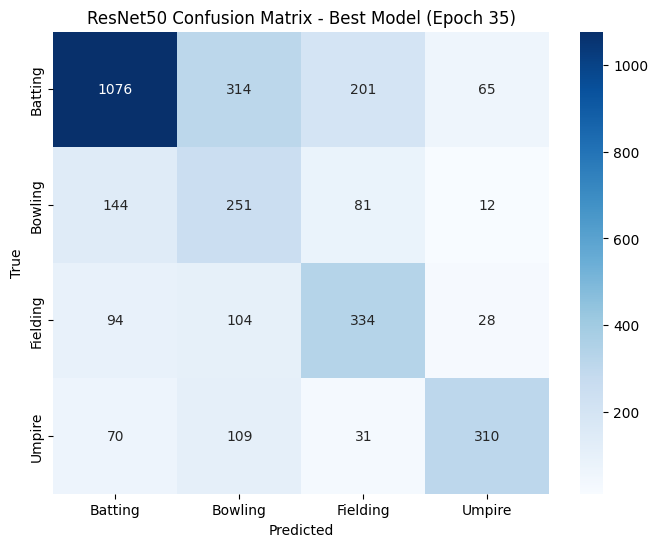

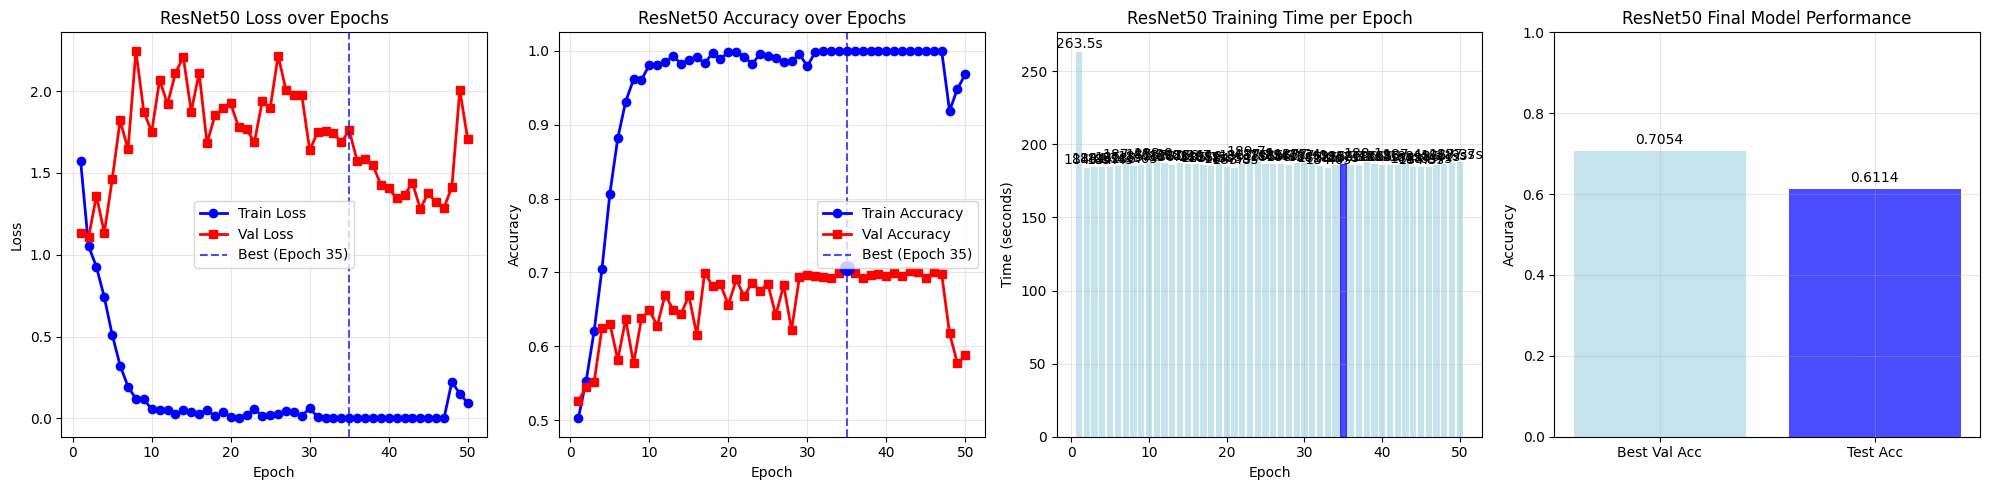


⏰ ResNet50 Final Timing Summary:
│ Total Training: 9385.46s
│ Average per Epoch: 187.71s
│ Testing Time: 53.06s
│ Total Runtime: 9438.52s

💾 ResNet50 Files saved:
│ best_resnet50_model.pth - Best validation accuracy model
│ resnet50_training_history.csv - Training metrics for later plotting

🏗️  ResNet50 Architecture Summary:
│ Total Parameters: 23,516,228
│ Trainable Parameters: 23,516,228
│ Model Size: 89.71 MB
│ Input Size: 224x224x3
│ Output Classes: 4
│ Architecture: ResNet50
│ Block Type: Bottleneck
│ Layers: [3, 4, 6, 3]
│ Skip Connections: Yes
│ Batch Normalization: Yes
│ Activation: ReLU
│ Zero Init Residual: Yes


In [10]:
# -----------------------------
# 4. Training Loop with Best Model Saving (Val Accuracy) - ResNet50
# -----------------------------
train_losses, val_losses = [], []
train_accs, val_accs = [], []
epoch_times = []
epochs = 50

# Initialize best model tracking
best_val_acc = 0.0
best_model_state = None
best_epoch = 0

print(f"\n🚀 Starting ResNet50 Training for {epochs} epochs...")
print("=" * 80)

total_start_time = time.time()

for epoch in range(epochs):
    epoch_start_time = time.time()
    
    print(f"\n📈 Epoch {epoch+1}/{epochs}")
    print("-" * 50)
    
    # Training Phase
    print("🔄 Training Phase...")
    model.train()
    running_loss, correct, total = 0, 0, 0
    
    train_pbar = tqdm(train_loader, desc=f"Training", 
                     bar_format='{l_bar}{bar:30}{r_bar}{bar:-30b}')
    
    train_phase_start = time.time()
    
    for batch_idx, (imgs, labels) in enumerate(train_pbar):
        imgs, labels = imgs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        
        current_acc = correct / total
        train_pbar.set_postfix({
            'Loss': f'{running_loss/(batch_idx+1):.4f}',
            'Acc': f'{current_acc:.4f}'
        })
        
        if device.type == 'cuda' and batch_idx % 10 == 0:
            gpu_memory = torch.cuda.memory_allocated() / 1024**3
            train_pbar.set_postfix({
                'Loss': f'{running_loss/(batch_idx+1):.4f}',
                'Acc': f'{current_acc:.4f}',
                'GPU': f'{gpu_memory:.1f}GB'
            })
    
    train_phase_time = time.time() - train_phase_start
    train_loss = running_loss / len(train_loader)
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    
    print(f"✅ Training completed in {train_phase_time:.2f}s")
    
    # Validation Phase
    print("🔍 Validation Phase...")
    model.eval()
    running_loss, correct, total = 0, 0, 0
    
    val_phase_start = time.time()
    val_pbar = tqdm(val_loader, desc=f"Validation", 
                   bar_format='{l_bar}{bar:30}{r_bar}{bar:-30b}')
    
    with torch.no_grad():
        for batch_idx, (imgs, labels) in enumerate(val_pbar):
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            
            current_acc = correct / total
            val_pbar.set_postfix({
                'Loss': f'{running_loss/(batch_idx+1):.4f}',
                'Acc': f'{current_acc:.4f}'
            })
    
    val_phase_time = time.time() - val_phase_start
    val_loss = running_loss / len(val_loader)
    val_acc = correct / total
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    print(f"✅ Validation completed in {val_phase_time:.2f}s")
    
    # Check if this is the best model so far based on val_acc
    is_best = val_acc > best_val_acc
    if is_best:
        best_val_acc = val_acc
        best_epoch = epoch + 1
        best_model_state = model.state_dict().copy()
        print(f"🌟 New best ResNet50 model found! Validation Accuracy: {val_acc:.4f}")
    
    # Epoch Summary
    epoch_time = time.time() - epoch_start_time
    epoch_times.append(epoch_time)
    
    print(f"\n📊 Epoch {epoch+1} Summary:")
    print(f"│ Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"│ Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.4f}")
    print(f"│ Train Time: {train_phase_time:.2f}s | Val Time: {val_phase_time:.2f}s")
    print(f"│ Total Epoch Time: {epoch_time:.2f}s")
    print(f"│ Best Val Acc: {best_val_acc:.4f} (Epoch {best_epoch})")
    
    if device.type == 'cuda':
        print(f"│ GPU Memory: {torch.cuda.memory_allocated()/1024**3:.1f}GB / {torch.cuda.memory_reserved()/1024**3:.1f}GB")
    
    print("=" * 80)

total_training_time = time.time() - total_start_time

# Save the best model
if best_model_state is not None:
    torch.save(best_model_state, 'best_resnet50_model.pth')
    print(f"\n💾 Best ResNet50 model saved as 'best_resnet50_model.pth'")
    print(f"📊 Best model stats:")
    print(f"│ Best Epoch: {best_epoch}")
    print(f"│ Best Val Acc: {best_val_acc:.4f}")

# Save training history data to CSV
history_data = {
    'epoch': list(range(1, epochs+1)),
    'train_loss': train_losses,
    'val_loss': val_losses,
    'train_acc': train_accs,
    'val_acc': val_accs,
    'epoch_time': epoch_times
}
history_df = pd.DataFrame(history_data)
history_df.to_csv('resnet50_training_history.csv', index=False)
print("\n💾 ResNet50 training history saved to 'resnet50_training_history.csv'")

# Training Summary
print(f"\n🎉 ResNet50 Training Complete!")
print(f"Total Training Time: {total_training_time:.2f}s ({total_training_time/60:.1f} minutes)")
print(f"Average Epoch Time: {np.mean(epoch_times):.2f}s")
print("\n⏱️  Epoch Timing Breakdown:")
for i, t in enumerate(epoch_times):
    print(f"│ Epoch {i+1}: {t:.2f}s")

# -----------------------------
# 5. Load Best Model and Test
# -----------------------------
print(f"\n🧪 Loading Best ResNet50 Model for Testing...")

# Load the best model state
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print(f"✅ Best ResNet50 model from epoch {best_epoch} loaded successfully!")
else:
    print("⚠️  No best model found, using current model state")

test_start_time = time.time()
y_true, y_pred = [], []
model.eval()

test_pbar = tqdm(test_loader, desc="Testing ResNet50", 
                bar_format='{l_bar}{bar:30}{r_bar}{bar:-30b}')

with torch.no_grad():
    for imgs, labels in test_pbar:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

test_time = time.time() - test_start_time
test_accuracy = accuracy_score(y_true, y_pred)

print(f"✅ ResNet50 Testing completed in {test_time:.2f}s")
print("\n📋 ResNet50 Classification Report:")
print(classification_report(y_true, y_pred, target_names=classes,digits=4))
print(f"🎯 ResNet50 Test Accuracy: {test_accuracy:.4f}")

# Model Performance Summary
print(f"\n📊 ResNet50 Model Performance Summary:")
print(f"│ Best Validation Acc:  {best_val_acc:.4f} (Epoch {best_epoch})")
print(f"│ Final Test Accuracy:  {test_accuracy:.4f}")
print(f"│ Val-Test Gap:         {abs(best_val_acc - test_accuracy):.4f}")

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title(f"ResNet50 Confusion Matrix - Best Model (Epoch {best_epoch})")
plt.show()

# -----------------------------
# 6. Enhanced Visualizations
# -----------------------------
plt.figure(figsize=(20, 5))

# Loss Plot
plt.subplot(1, 4, 1)
plt.plot(range(1, epochs+1), train_losses, 'b-', label="Train Loss", marker='o', linewidth=2)
plt.plot(range(1, epochs+1), val_losses, 'r-', label="Val Loss", marker='s', linewidth=2)
plt.axvline(x=best_epoch, color='blue', linestyle='--', alpha=0.7, label=f'Best (Epoch {best_epoch})')
plt.legend()
plt.title("ResNet50 Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True, alpha=0.3)

# Accuracy Plot
plt.subplot(1, 4, 2)
plt.plot(range(1, epochs+1), train_accs, 'b-', label="Train Accuracy", marker='o', linewidth=2)
plt.plot(range(1, epochs+1), val_accs, 'r-', label="Val Accuracy", marker='s', linewidth=2)
plt.axvline(x=best_epoch, color='blue', linestyle='--', alpha=0.7, label=f'Best (Epoch {best_epoch})')
plt.scatter([best_epoch], [best_val_acc], color='blue', s=100, zorder=5)
plt.legend()
plt.title("ResNet50 Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True, alpha=0.3)

# Timing Plot
plt.subplot(1, 4, 3)
bars = plt.bar(range(1, epochs+1), epoch_times, color='lightblue', alpha=0.7)
bars[best_epoch-1].set_color('blue')
plt.title("ResNet50 Training Time per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Time (seconds)")
plt.grid(True, alpha=0.3)
for i, t in enumerate(epoch_times):
    plt.text(i+1, t+0.5, f'{t:.1f}s', ha='center', va='bottom')

# Performance Comparison
plt.subplot(1, 4, 4)
metrics = ['Best Val Acc', 'Test Acc']
values = [best_val_acc, test_accuracy]
colors = ['lightblue', 'blue']
bars = plt.bar(metrics, values, color=colors, alpha=0.7)
plt.title("ResNet50 Final Model Performance")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.grid(True, alpha=0.3)
for bar, val in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width()/2, val + 0.01, 
             f'{val:.4f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

print(f"\n⏰ ResNet50 Final Timing Summary:")
print(f"│ Total Training: {total_training_time:.2f}s")
print(f"│ Average per Epoch: {np.mean(epoch_times):.2f}s")
print(f"│ Testing Time: {test_time:.2f}s")
print(f"│ Total Runtime: {total_training_time + test_time:.2f}s")

print(f"\n💾 ResNet50 Files saved:")
print(f"│ best_resnet50_model.pth - Best validation accuracy model")
print(f"│ resnet50_training_history.csv - Training metrics for later plotting")

# -----------------------------
# 7. ResNet50 Architecture Summary
# -----------------------------
print(f"\n🏗️  ResNet50 Architecture Summary:")
print(f"│ Total Parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"│ Trainable Parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")
print(f"│ Model Size: {sum(p.numel() * p.element_size() for p in model.parameters()) / 1024**2:.2f} MB")
print(f"│ Input Size: 224x224x3")
print(f"│ Output Classes: {len(classes)}")
print(f"│ Architecture: ResNet50")
print(f"│ Block Type: Bottleneck")
print(f"│ Layers: [3, 4, 6, 3]")
print(f"│ Skip Connections: Yes")
print(f"│ Batch Normalization: Yes")
print(f"│ Activation: ReLU")
print(f"│ Zero Init Residual: Yes")


In [11]:
import pandas as pd
df=pd.read_csv("/kaggle/working/resnet50_training_history.csv")
df

,epoch,train_loss,val_loss,train_acc,val_acc,epoch_time
0,1,1.572479,1.131333,0.502619,0.525621,263.499411
1,2,1.052967,1.105494,0.553485,0.545031,183.955354
2,3,0.925984,1.359474,0.620266,0.551242,184.536202
3,4,0.739288,1.133872,0.704674,0.625000,184.679500
4,5,0.510949,1.461462,0.806708,0.630823,184.360162
5,6,0.322785,1.820033,0.881648,0.581910,185.092276
6,7,0.194295,1.643066,0.931205,0.636646,187.392352
7,8,0.118872,2.246238,0.961221,0.576863,184.965568
8,9,0.116029,1.872340,0.960516,0.637811,185.790400
9,10,0.056301,1.750357,0.980963,0.648680,187.186312


In [12]:
import random
import openpyxl

# -----------------------------
# Save Misclassified Images Info to Excel
# -----------------------------
misclassified_records = []
os.makedirs("misclassified", exist_ok=True)
os.makedirs("gradcam", exist_ok=True)

for idx, (img_tensor, true_lbl, pred_lbl) in enumerate(misclassified):
    # Undo normalization for saving
    img = inv_normalize(img_tensor).permute(1, 2, 0).numpy()
    img = np.clip(img * 255, 0, 255).astype(np.uint8)

    filename = f"misclassified/img_{idx}_true_{classes[true_lbl]}_pred_{classes[pred_lbl]}.png"
    cv2.imwrite(filename, cv2.cvtColor(img, cv2.COLOR_RGB2BGR))

    misclassified_records.append({
        "Index": idx,
        "True_Label": classes[true_lbl],
        "Pred_Label": classes[pred_lbl],
        "File": filename
    })

# Save details to Excel
misclassified_df = pd.DataFrame(misclassified_records)
misclassified_df.to_excel("misclassified_images.xlsx", index=False)
print(f"💾 Misclassified details saved to 'misclassified_images.xlsx'")
print(f"📌 Total misclassified images saved: {len(misclassified_records)}")

# -----------------------------
# Save 5 Grad-CAM Overlays
# -----------------------------
print("\n🔥 Saving 10 Grad-CAM overlays...")
sampled_misclassified = random.sample(misclassified, min(10, len(misclassified)))

for idx, (img_tensor, true_lbl, pred_lbl) in enumerate(sampled_misclassified):
    img = inv_normalize(img_tensor).permute(1, 2, 0).numpy()
    img = np.clip(img * 255, 0, 255).astype(np.uint8)

    input_img = img_tensor.unsqueeze(0).to(device)
    cam = gradcam(input_img, class_idx=pred_lbl)

    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(cv2.cvtColor(img, cv2.COLOR_RGB2BGR), 0.6, heatmap, 0.4, 0)

    gradcam_path = f"gradcam/gradcam_{idx}_true_{classes[true_lbl]}_pred_{classes[pred_lbl]}.png"
    cv2.imwrite(gradcam_path, overlay)

print("✅ 10 Grad-CAM images saved in 'gradcam/' folder")

NameError: name 'os' is not defined